# baseline

In [ ]:
!pip install -q langchain langgraph transformers bitsandbytes langchain-huggingface langchain-community chromadb
!pip install -U bitsandbytes

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

將`關鍵字`比對換成`向量相似度`比對。

> 請將目前使用關鍵字比對的 route_by_query，改為使用向量相似度進行分類，並設一個合理的相似度門檻，根據檢索結果的分數判斷是否走 RAG 流程。  
例如用向量相似度及自訂 threshold 決定要不要分到 retriever。

> Hint：similarity_search_with_score(...)  
可參考去年的讀書會 R4：向量資料庫的基本操作

In [3]:
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

docs_text = """
火影代數	姓名	師傅	徒弟
初代	千手柱間	無明確記載	猿飛日斬、水戶門炎、轉寢小春
二代	千手扉間	千手柱間（兄長）	猿飛日斬、志村團藏、宇智波鏡等
三代	猿飛日斬	千手柱間、千手扉間	自來也、大蛇丸、千手綱手（傳說三忍）
四代	波風湊	自來也	旗木卡卡西、宇智波帶土、野原琳
五代	千手綱手	猿飛日斬	春野櫻、志乃等（主要為春野櫻）
六代	旗木卡卡西	波風湊	漩渦鳴人、宇智波佐助、春野櫻（第七班）
七代	漩渦鳴人	自來也、旗木卡卡西	木葉丸等（主要為木葉丸）
""".strip()

docs = []
for line in docs_text.split("\n")[1:]:  # 跳過首行標題
    gen, name, master, apprentices = line.split("\t")
    content = f"代數：{gen}，姓名：{name}，師傅：{master}，徒弟：{apprentices}"
    docs.append(Document(page_content=content, metadata={
        "generation": gen,
        "name": name
    }))

# chromadb 預設使用的大型語言模型為 "all-MiniLM-L6-v2"，由於該大型語言模型不支持中文，所以將模型替換為 "infgrad/stella-base-zh-v3-1792d"，並對 embedding 進行量化
embedding_model = HuggingFaceEmbeddings(
    model_name="infgrad/stella-base-zh-v3-1792d",
    encode_kwargs={"normalize_embeddings": True}
)

persist_path = "document_store"
collection_name = "naruto_collection"
vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embedding_model,
    persist_directory=persist_path,
    collection_name=collection_name,
    collection_metadata={"hnsw:space": "cosine"}
)

<ipython-input-3-092efacfc581>:26: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
Some weights of BertModel were not initialized from the model checkpoint at infgrad/stella-base-zh-v3-1792d and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

Device set to use cuda:0


In [5]:
from typing_extensions import TypedDict, List

# 定義 LangGraph 的 State 結構
class RAGState(TypedDict):
    query: str
    docs: List[Document]
    answer: str

In [6]:
def retrieve_node(state: RAGState) -> RAGState:
    query = state["query"]
    # similarity_search 距離越小越相似
    docs = vectorstore.similarity_search(query, k=3)
    return {"query": query, "docs": docs, "answer": ""}

def generate_node(state: RAGState) -> RAGState:
    query, docs = state["query"], state["docs"]
    context = "\n".join([d.page_content for d in docs])
    prompt = (
        f"你是一個知識型助手，請根據以下內容回答問題：\n\n"
        f"內容：{context}\n\n"
        f"問題：{query}\n\n回答："
    )
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"query": query, "docs": docs, "answer": output}

def direct_generate_node(state: RAGState) -> RAGState:
    query = state["query"]
    prompt = f"請回答以下問題：{query}\n\n回答："
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"query": query, "docs": [], "answer": output}

# 定義 Route Node（決定走哪條路）
def route_by_query(state):
    query = state["query"]
    top_doc, score = Chroma.from_documents(docs, embedding_model).similarity_search_with_score(query, k=3)[0]
    choice = "naruto" if score <= 1.1 else "general"
    print(f"相關性 = {score}；跑到 → {choice}")
    return choice

In [7]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END

# 建立 LangGraph 流程圖
graph_builder = StateGraph(RAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

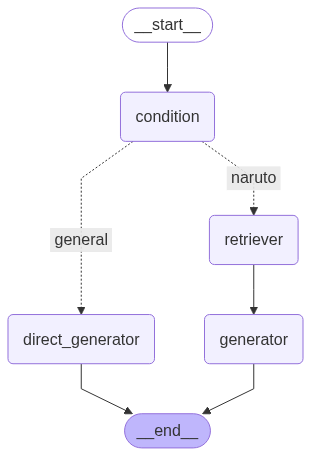

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [9]:
print("開始對話吧（輸入 q 結束）")
while True:
    user_input = input("使用者: ")
    if user_input.strip().lower() in ["q", "quit", "exit"]:
        print("掰啦！")
        break

    # 設定初始 State
    init_state: RAGState = {
        "query": user_input,
        "docs": [],
        "answer": ""
    }
    # 呼叫 LangGraph
    result = graph.invoke(init_state)
    raw_output = result["answer"]

    answer_text = raw_output.split("回答：")[-1].strip()
    print("回答：", answer_text)
    print("===" * 20, "\n")

開始對話吧（輸入 q 結束）
使用者: 四代火影是誰
相關性 = 0.49396461248397827；跑到 → naruto


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


回答： 四代火影是波風湊，他的師傅是自來也，他的徒弟有旗木卡卡西、宇智波帶土、野原琳。

使用者: q
掰啦！


# advance

改成能支援多輪問答（Multi-turn RAG），並能根據前面的query判斷問題。

> 請將 RAGState 加入 history 欄位，並在生成回答時，將歷史對話與當前問題一起組成 prompt。

> Hint：
```
class MultiTurnRAGState(TypedDict):  
    history: List[str]  
    query: str  
    docs: List[Document]  
    answer: str
```



In [10]:
from langchain.schema import Document, AIMessage, HumanMessage
from typing_extensions import TypedDict, List

class MultiTurnRAGState(TypedDict):
    history: List[str]
    query: str
    docs: List[Document]
    answer: str

In [11]:
def retrieve_node(state: MultiTurnRAGState) -> MultiTurnRAGState:
    history, query = state["history"], state["query"]
    # similarity_search 距離越小越相似
    docs = vectorstore.similarity_search(state["query"], k=3)
    return {"history": history, "query": query, "docs": docs, "answer": ""}

def generate_node(state: MultiTurnRAGState) -> MultiTurnRAGState:
    history, query, docs = state["history"], state["query"], state["docs"]
    context = "\n".join([d.page_content for d in docs])
    history_tex = "\n".join([f"History: {h}" for h in state["history"]])
    prompt = (
        f"你是一個知識型助手，請根據以下內容與對話歷史回答問題：\n\n"
        f"內容: {context}\n\n"
        f"歷史回答: {history_tex}\n\n"
        f"問題: {state['query']}\n\n回答: "
    )
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"history": history + [query], "query": query, "docs": docs, "answer": output}

def direct_generate_node(state: MultiTurnRAGState) -> MultiTurnRAGState:
    history, query = state["history"], state["query"]
    history_tex = "\n".join([f"History: {h}" for h in state["history"]])
    prompt = (
        f"請根據以下內容與歷史對話回答問題：\n\n"
        f"歷史回答: {history_tex}\n\n"
        f"問題: {state['query']}\n\n回答: "
    )
    output = generator(prompt, max_new_tokens=200)[0]["generated_text"]
    return {"history": history + [query], "query": query, "docs": [], "answer": output}

# 定義 Route Node（決定走哪條路）
def route_by_query(state: MultiTurnRAGState) -> str:
    history, query = state["history"], state["query"]
    history_text = "\n".join(history + [query])
    top_doc, score = Chroma.from_documents(docs, embedding_model).similarity_search_with_score(query, k=3)[0]
    choice = "naruto" if score <= 1.1 else "general"
    print(f"使用者: {query}")
    print(f"相關性 = {score}；跑到 → {choice}")
    print(f"retrieve combined query: {repr(history_text)}") if score <= 1.1 else None
    return choice

In [12]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END

# 建立 LangGraph 流程圖
graph_builder = StateGraph(MultiTurnRAGState)

graph_builder.set_entry_point("condition")
graph_builder.add_node("condition", RunnableLambda(lambda x: x))  # 進來就分流，不改變內容
graph_builder.add_node("retriever", RunnableLambda(retrieve_node))
graph_builder.add_node("generator", RunnableLambda(generate_node))
graph_builder.add_node("direct_generator", RunnableLambda(direct_generate_node))

# 設定條件分流
graph_builder.add_conditional_edges(
    source="condition",
    path=RunnableLambda(route_by_query),
    path_map={
        "naruto": "retriever",
        "general": "direct_generator",
    }
)

# 接下來的正常連接
graph_builder.add_edge("retriever", "generator")
graph_builder.add_edge("generator", END)
graph_builder.add_edge("direct_generator", END)

# 編譯 Graph
graph = graph_builder.compile()

In [13]:
global_history: List[str] = []
for user_input in ["四代火影是誰?", "他的師父是誰?", "他的徒弟是誰?", "相對論是他發明的嗎?"]:
    state = {"history": global_history, "query": user_input}
    result = graph.invoke(state)

    answer = result["answer"].split("回答：")[-1].strip()
    print("AI 助理:", answer)
    print("===" * 60, "\n")

    global_history = result["history"]

使用者: 四代火影是誰?
相關性 = 0.5165642499923706；跑到 → naruto
retrieve combined query: '四代火影是誰?'
AI 助理: 四代火影是波風湊，他的師傅是自來也，徒弟有旗木卡卡西、宇智波帶土、野原琳。

使用者: 他的師父是誰?
相關性 = 0.9923335313796997；跑到 → naruto
retrieve combined query: '四代火影是誰?\n他的師父是誰?'
AI 助理: 四代火影波風湊的師父是自來也。

使用者: 他的徒弟是誰?
相關性 = 0.9885889291763306；跑到 → naruto
retrieve combined query: '四代火影是誰?\n他的師父是誰?\n他的徒弟是誰?'
AI 助理: 四代火影的徒弟是旗木卡卡西、宇智波帶土、野原琳。

使用者: 相對論是他發明的嗎?
相關性 = 1.2265353202819824；跑到 → general
AI 助理: 相對論不是由四代火影發明的。相對論是由愛因斯坦（Albert Einstein）在1905年提出的。相對論是一種理論，描述了空間和時間的基本性質，以及物質和能量的相互轉換。愛因斯坦的這個理論改變了我們對宇宙的理解，包括重力、時間和空間的關係。

